This notebook includes my notes extracted from the references in order to understand how Generative Adversarial Networks work, a lot of this production is not mine and I would like reference the credit for the authors. 

# Generative Adversarial Network


This is a kind of reinforcement learning and unsupervised learning where two models play together. We will have a real dataset R, a model __G__ knows as *generator* which is going to create fake data that looks just like the genuine data, while **D** is the *discriminator* who is going to evaluate and calculate the differente between the real set and the set that was modified, finally, we are going to have the *I* random noise that goes into the generator as source of entropy.


<img src="https://miro.medium.com/max/1198/1*-gFsbymY9oJUQJ-A3GTfeg.png" >


R, we are going to start with the simplest possible **R**. This function takes a mean and a standard deviation and returns which provides the right shape of a sample data from a Gaussian with those parameters. 

So, given a set of data instances X and a set of labels Y, we are going to have }
+ _Generative_ models capture the joind probability P(X, Y), or just P(X) if there are no labels
+ _Discriminative_ models capture the conditional probability P(Y|X)

<img src="https://developers.google.com/machine-learning/gan/images/generative_v_discriminative.png" >

This is the general architecture of the system

<img src="https://developers.google.com/machine-learning/gan/images/gan_diagram.svg" >

Both the generator and the discrimator are neuronal networks, where the discriminator is a classifier which knows the distribution of the data and how to segment it, in the same way, it has a backpropation which uses the loss from the interactions. 

<img src="https://developers.google.com/machine-learning/gan/images/gan_diagram_discriminator.svg">

During the discriminator's training, the discriminator ignores the generator's loss and uses the discriminator's loss, in the same way, during the generator's training the generator uses its loss.

The discriminator is going to focus to classify both real data and fake from the generator, moreover, the discriminator's loss is going to penalize the discriminator for misclassifiying a real instance as fake or a fake instance as real, finally, the discriminator updates its weights using backpropagation from the discrimator's loss. 

The generator is focuses to make fake data using the feedback from the discriminator, in other words, it learns from it in order to improve its output to be the more real. 

G is integrated by the random input _I_, a neural network, the discriminator's output, generator's loss which penalizes the generator for failing to fool the discriminator.

The *loss functions* use in a GAN are:
+ __minmax loss__
+ __Wasserstein loss__

Due to we have two neural nets we can have two loss functions. 


## GAN Variations




+ *Progressive GANs*, it's generator's first layers produce very low resolution images, and subsequent layers and details. This a kind of technique faster than the others. 

+ *Conditional GANs*, in this technique we can specify the label for each generated instance, completely different from *unconditional GANs* where it produces random outputs. 

+ *Image-to-Image translation* it takes an image as input and map it to a generated output image with different properties. 

+ *CycleGAN* it lerans to transform images from one set into images that could belong to another set. 

+ *Text-to-Image Synthesis* takes text as input and produce images that plausible and described by the text. 

+ *Super-resolution* increases the resolution of images, adding detail where necessary to fill in blurry areas. 

+ *Face inpainting* the idea of this approach is to fill chunks of an image that are blacked out.

+ *Text-to-Speech* some researches explored the application of GANs to produce synthetized speech from text input. 

+ *Deep Convolutional Generative Adversarial Network (DCGAN)* is a direct extension of the GAN, except that it uses convolutional and convolutional-transpose layers in the discriminator and generator models, firt described by [8].

## Examples

### TF-GAN tutorial from Google Developers

The idea of this tutorial is to use a TF-GAN in the MNIST datasets to make fake data

**evaluating generative models, and evaluating GANs**

tf_scan provides some standard methods of evaluating generative models, we measure:
+ Inception Score: called `mnist_score`
+ Frechet Inception Distance

The idea is using the pre-trained classifier to both the real data and the generated data calculate the *Inception Score*, where its idea is measure both __quality__ and __diversity__ [4].

On the other hand, we can find the *Frechet Inception Distance* [5] which calculates how close the generated image distribution is to the real image distribution. 

In [1]:
# tensorflow-gan is a library for training and evaluating GANs
import tensorflow as tf
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as pd 
%matplotlib inline
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

W0210 08:14:52.450892 13468 module_wrapper.py:138] From D:\Usuarios\rhaps\Anaconda3\lib\site-packages\tensorflow_gan\python\estimator\tpu_gan_estimator.py:42: The name tf.estimator.tpu.TPUEstimator is deprecated. Please use tf.compat.v1.estimator.tpu.TPUEstimator instead.



In [3]:
tf.__version__

'2.1.0'

In [2]:
# random inputs for the generator  
def input_fn(mode, params):
    # assertions are statemets that assert or state a fact confidently, they are simply boolean expressions 
    assert "batch_size" in params
    assert "noise_dims" in params
    bs = params["batch_size"]
    nd = params["noise_dims"]
    split = "train" if mode == tf.estimator.ModeKeys.TRAIN else "test"
    shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
    just_noise = (mode == tf.estimator.ModeKeys.PREDICT)
    noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random.normal([bs, nd])))
    
    if just_noise:
        return noise_ds
    
    def _preprocess(element):
        # Map [0, 255] to [-1, 1]
        images = (tf.cast(element["image"], tf.float32) - 127.5) / 127.5
        return images
    
    images_ds =  (tfds.load("mnist", split=split).map(_preprocess).cache().repeat())
    
    if shuffle:
        images_ds = images_ds.shuffle(buffer_size=10000, reshuffle_each_iteration=True)
        images_ds = (images_ds.batch(bs, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))
        
    return tf.data.Dataset.zip((noise_ds, images_ds))
    
    

Cause: could not parse the source code:

              .map(lambda _: tf.random.normal([bs, nd])))

This error may be avoided by creating the lambda in a standalone statement.



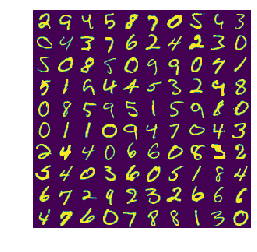

In [3]:
import numpy as np 
params = {"batch_size": 100, "noise_dims":64}
with tf.Graph().as_default():
    ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
    numpy_imgs = next(tfds.as_numpy(ds))[1]
img_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(10, 10))
plt.axis("off")
plt.imshow(np.squeeze(img_grid))
plt.show()

In [6]:
# neural network architecture 

# a generator that takes input noise and outputs generated MNIST digits
# a discriminator that takes images and outputs a probability of being real or fake

def _dense(inputs, units, l2_weight):
      return tf.keras.layers.Dense(
      inputs, units, None,
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))
        
def _batch_norm(inputs, is_training):
      return tf.keras.layers.batch_normalization(
      inputs, momentum=0.999, epsilon=0.001, training=is_training)

def _deconv2d(inputs, filters, kernel_size, stride, l2_weight):
      return tf.keras.layers.conv2d_transpose(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=tf.nn.relu, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _conv2d(inputs, filters, kernel_size, stride, l2_weight):
      return tf.keras.layers.conv2d(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=None, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))


In [13]:
def unconditional_generator(noise, mode, weight_decay=2.5e-5):
    """Generator to produce unconditional MNIST images."""
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    net = _dense(noise, 1024, weight_decay)
    net = _batch_norm(net, is_training)
    net = tf.nn.relu(net)

    net = _dense(net, 7 * 7 * 256, weight_decay)
    net = _batch_norm(net, is_training)
    net = tf.nn.relu(net)

    net = tf.reshape(net, [-1, 7, 7, 256])
    net = _deconv2d(net, 64, 4, 2, weight_decay)
    net = _deconv2d(net, 64, 4, 2, weight_decay)
    # Make sure that generator output is in the same range as `inputs`
    # ie [-1, 1].
    net = _conv2d(net, 1, 4, 1, 0.0)
    net = tf.tanh(net)

    return net

In [8]:
_leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)

def unconditional_discriminator(img, unused_conditioning, mode, weight_decay=2.5e-5):
    is_training= (mode == tf.estimator.ModeKeys.TRAIN)
    
    net = _conv2d(img, 64, 4, 2, weight_decay)
    net = _leaky_relu(net)
    
    net = _conv2d(net, 128, 4, 2, weight_decay)
    net = _leaky_relu(net)
    
    net = tf.keras.layers.flatten(net)
    
    net = _dense(net, 1024, weight_decay)
    net = _batch_norm(net, is_training)
    net = _leaky_relu(net)
    
    net = _dense(net, 1, weight_decay)
    
    return net

In [9]:
from tensorflow_gan.examples.mnist import util as eval_util
import os

# evaluation function
def get_eval_metric_ops_fn(gan_model):
    real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
    gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)
    real_mnist_logits = eval_util.mnist_score(gan_model.real_data)
    # inception score
    generated_mnist_score = eval_util.mnist_score(gan_model.generated_data)
    # frechet inception distance
    frechet_distance =  eval_util.mnist_frechet_distance(gan_model.real_data, gan_model.generated_data)
    return {
        'real_data_logits': tf.metrics.mean(real_data_logits),
        'gen_data_logits': tf.metrics.mean(gen_data_logits),
        'real_mnist_socre': tf.metrics.mean(real_mnist_score),
        'mnist_score': tf.metrics.mean(generated_mnist_score),
        'frechet_distance': tf.metrics.mean(frechet_distance)
    }
    

GANEstimator assembles and manages the pieces of the whole GAN model, where it's contructor takes the following components:
+ Network builder functions
+ Loss functions
+ Optimizers

In [10]:
train_batch_size =  32 
noise_dimensions = 64
generator_lr = 0.001
discriminator_lr = 0.0002

def gen_opt():
    gstep =  tf.train.get_or_create_step()
    base_lr = generator_lr
    lr = tf.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
    return tf.optimizers.Adam(lr, 0.5)

gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=unconditional_generator,
    discriminator_fn=unconditional_discriminator,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    params={'batch_size': train_batch_size, 'noise_dims': noise_dimensions},
    generator_optimizer=gen_opt,
    discriminator_optimizer=tf.optimizers.Adam(discriminator_lr, 0.5),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn)

*Train and eval loop*

In [14]:
tf.autograph.set_verbosity(0, False)

import time 
steps_per_eval = 500
max_train_steps =  5000
batches_for_eval_metrics = 100

# used to track metrics
steps = []
real_logits, fake_logits = [], []
real_mnist_scores, mnist_scores, frechet_distances = [], [], []

cur_step =  0
start_time =  time.time()
while cur_step < max_train_steps:
    next_step = min(cur_step + steps_per_eval, max_train_steps)
    
    start = time.time()
    gan_estimator.train(input_fn, max_steps=next_step)
    steps_taken = next_step - cur_step
    time_taken =  time.time() - start
    
    print("Time since start: %.2f min" %((time.time() - start_time / 60.0)))
    print("Trained from step %i to %i in %.2f steps / sec" %(cur_step, next_step, steps_taken / time_taken))
cur_step = next_step

# calculate some metrics

metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics)
steps.append(cur_step)
real_logits.append(metrics["real_data_logits"])
fake_logits.append(metrics["gen_data_logits"])
real_mnist_scores.append(metrics["real_mnist_score"])
mnist_scores.append(metrics["frechet_distance"])
print("Average discriminator output on Real: %.2f Fake: %.2f %" % (real_logits[-1], fake_logits[-1]))
print("Inception Score: %.2f / %.2f Frechet Distance: %.2f" %(mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Tensor'

### GAN in depth

In [1]:
# mean of 4.0 and a standard deviation of 1.25
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))

G, the generator is a standard feedforward graph - two hidden layers, three linear maps. The idea is G is going to receive the *uniformly* distributed data samples from *I* and somehow replicate the *normally* distributed samples from R.

In [2]:
def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)

In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, sample_interval=200)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

D:\Usuarios\rhaps\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.836386, acc.: 51.56%] [G loss: 0.870476]


FileNotFoundError: [Errno 2] No such file or directory: 'images/0.png'

## Conditional GAN


This approach [6] 

https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

another

## DCGAN




The next example is published in [8], where the idea is to use GAN in a set of celebrities photos. The dataset can be downladed from this URL http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html, which has 202,599 face images.

*Libraries*

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [19]:
dataroot = "../../../Datasets/celeba"
workers = 2
batch_size = 128
# Spatial size of training images. All images will be resized to this size using a transformer
image_size = 64
# number of channels in the training images. For color images this is 3
nc = 3
# size of z latent vector (i.e size of generator input)
ngpu = 1

*Loading the data*

In [20]:
dataset = dset.ImageFolder(root=dataroot,
                          transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          ]))

# dataloader 
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
# decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

*Let's print a set of images*

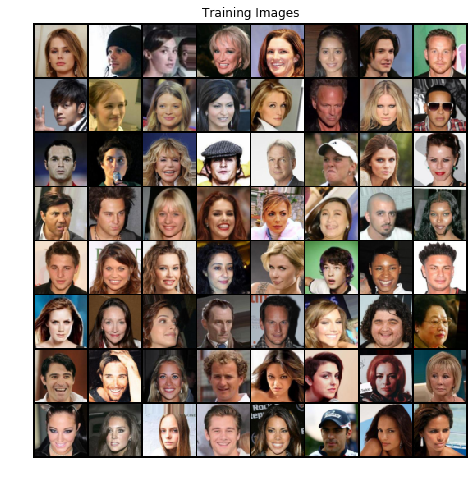

In [23]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

The autors [8] mentions that all model weights shall be randomly initialized from a normal distribution with mean=0, stdev=0.02. The next function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. 

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != 1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

*DCGAN* image processing
<img src="https://pytorch.org/tutorials/_images/dcgan_generator.png" >

*Defining the models*

In [7]:
class Generator(nn.Module):
    
    def __init__(self, input_size, hidden_dim, output_size, ngpu):
        super(Generator, self).__init__()
        
        # gpus
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
        # Input is Z, going into a convolution
            #torch.nn.ConvTranspose2d(in_channels, out_channels, 
            # kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, 
            # dilation=1, padding_mode='zeros'
            nn.ConvTranspose2d(input_size, hidden_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.ReLu(True)
            # state size. (hidden_dim x 8) x 4 x 4
            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(True),
             # state size. (hidden_dim x 4) x 8 x 8
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False)
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # state size. (hidden_dim x 2) x 16 x 16
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False)
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # state size. (hidden_dim) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (number_channels) x 64 x 64
        )
        
        
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, input):       
        return self.main(input) 

In [28]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    
    def __init__(self, nc, hidden_dim, output_size, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        # define hidden linear layers
        self.main = nn.Sequential
        (
            # input is (number of channels - nc) x 64 x 64
            nn.Conv2d(nc, hidden_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hidden_dim) x 32 x 32
            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hidden_dim*2) x 16 x 16
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hidden_dim*4) x 8 x 8
            nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hidden_dim*8) x 4 x 4
            nn.Conv2d(hidden_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):       
        return self.main(input)

*Let's build the complete network*

In [29]:
# Create the Discriminator 
netD = Discriminator(nc, 64, ).to(device)
# handle multi-gpu if desired 
if (device.type == "cuda") and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights to mean=0, stdev = 0.2
netD.apply(weights_init)
print(netD)

TypeError: __init__() missing 3 required positional arguments: 'hidden_dim', 'output_size', and 'ngpu'

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

## MNIST

The next examples was taken from [11] where the idea is to use GAN for make fake data from MNIST.

*packages*

In [2]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

*loading the data*

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms

# subprocess to use for data loading
workers = 0
# how many samples per batch to load
batch_size = 64
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="data", train=True, download=True, transform= transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=workers)

*Visualize the data*

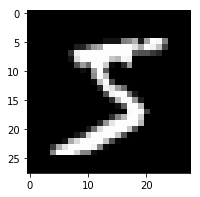

In [8]:
digit = iter(train_loader)
images, labels = digit.next()
images = images.numpy()
img = np.squeeze(images[0])

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap="gray")

*Defining the model*

Our descriminator network is going to be a typical linear classifier, all hidden layers will have a Leaky ReLu activation function [10] applied to their outputs, according to [11] we should have the next schema for defining a model:
+ in the first layer, we need to flatten the image
+ define the structure of all hidden linear layers
+ add a dropout layer to avoid overfitting
+ once the hidden structure was done we must propose the fully-connected layer

__Discrimator__

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)
        
        return out

**Generator**

This is similar like the discrimator with a difference that it uses a tanh activation function to our output layer, where the idea is scales the output between -1 and 1. According to [11], the next is the structure for our generator model. 
+ It is a part to define all hidden linear layers
+ Once the hidden part was defined so the idea is to connect it with a fully-connected layer
+ add a dropout layer to avoid the overfitting
+ in the last layer the idea is applying a tanh function.

In [30]:
class Generator(nn.Module):
    
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))
        return out 

**Model hyperparameters**

This a good part to experiment
1. Size of the input image to descriminator (28*28=784)
2. Size of descriminator output (real or fake)
3. Size of last hidden layer in the discriminator
4. Size of latent vector to give to the generator
5. Size of discriminator output (generated image)
6. Size of first hidden layer in the generator

In [31]:
# Dicrimnator hyperparams

# Size of input image to discrimator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discrimator output (generated image)
g_output_size = 784
# Size of first hidden layer in generator
g_hidden_size = 32

*Let's build the complete network*

In [32]:
# insstantiate discriminator and generator 
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

In [33]:
print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


**Defining losses**

+ *For the discriminator*, the total loss is the sum of the losses for real and fake 

$ \text{image}, \text{d_loss}= \text{d_real_loss} + \text{d_fake_loss} $

+ For this case we want the descriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that. 

+ The generator loss will look similar only with flipped labels. The generator's goal is to get D(fake_image)=1


In [34]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
    # smooth, real labels = 0.9
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss


**Optimizers**

The idea is to update the generator and discriminator variables individually

In [38]:
import torch.optim as optim 

# Optimizers

lr = 0.002 

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

**Training**

These are the activities in both neural networks.

*Discriminator training*
1. Compute the discriminator loss on real, training images
2. Generate fake images
3. Compute the discriminator loss on fake, generated images.
4. Add up the real and fake losses
5. Perform backpropagation + an optimization step to update the descriminator's weights

*Generator training*
1. Generate fake images
2. Compute the discriminator loss on fake images, using *Flipped* labels
3. Perform backpropagation + an optimization step to update the discriminato's weights. 


In [42]:
from datetime import datetime
import pickle as pkl 


start=datetime.now()

# training hyperparameters
num_epochs = 100
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images tht are held
# constant throughout, and allow us to inspect the model's performance 
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    for batch_i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = real_images * 2-1 # rescale input images from [0,1) to [-1, 1)
        
        # ---train the discriminator
        d_optimizer.zero_grad()
        # 1. train with real images
        # compute the discriminator losses on real images
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. train with fake images
        
        # generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up the loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # ---train the generator
        g_optimizer.zero_grad()
        
        # 1. train with fake images and flipped labels
        
        # generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # compute the discriminator losses on fake images
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
        
        # print some loss stats
        if batch_i % print_every == 0:
            # printing the discriminator and generator losses
            print("Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}".format(epoch+1, num_epochs, d_loss.item(),
                                                                                  g_loss.item()))
    # after each epoch the idea is to append the discriminator and generator lossses
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode
    
# save the training generator samples
with open("train_samples.pkl", "wb") as f:
    pkl.dump(samples, f)
    
# print the time that the algorithm takes      

print (datetime.now()-start)

Epoch [    1/  100] | d_loss: 0.7146 | g_loss: 4.3246
Epoch [    1/  100] | d_loss: 1.2395 | g_loss: 1.1246
Epoch [    1/  100] | d_loss: 1.2407 | g_loss: 0.9284
Epoch [    2/  100] | d_loss: 1.1805 | g_loss: 0.9175
Epoch [    2/  100] | d_loss: 0.9218 | g_loss: 1.4583
Epoch [    2/  100] | d_loss: 1.0773 | g_loss: 1.9413
Epoch [    3/  100] | d_loss: 1.0598 | g_loss: 1.7568
Epoch [    3/  100] | d_loss: 1.0221 | g_loss: 1.4647
Epoch [    3/  100] | d_loss: 1.0479 | g_loss: 1.5988
Epoch [    4/  100] | d_loss: 1.1669 | g_loss: 2.0837
Epoch [    4/  100] | d_loss: 0.8550 | g_loss: 2.1305
Epoch [    4/  100] | d_loss: 1.2312 | g_loss: 1.0901
Epoch [    5/  100] | d_loss: 1.1259 | g_loss: 1.1048
Epoch [    5/  100] | d_loss: 0.9413 | g_loss: 1.2967
Epoch [    5/  100] | d_loss: 1.1337 | g_loss: 1.1700
Epoch [    6/  100] | d_loss: 1.1484 | g_loss: 1.2350
Epoch [    6/  100] | d_loss: 1.1403 | g_loss: 1.3754
Epoch [    6/  100] | d_loss: 1.0789 | g_loss: 1.5001
Epoch [    7/  100] | d_loss

Epoch [   51/  100] | d_loss: 1.2706 | g_loss: 1.0002
Epoch [   51/  100] | d_loss: 1.3138 | g_loss: 1.0970
Epoch [   52/  100] | d_loss: 1.3370 | g_loss: 1.3761
Epoch [   52/  100] | d_loss: 1.2694 | g_loss: 0.9111
Epoch [   52/  100] | d_loss: 1.3135 | g_loss: 1.0140
Epoch [   53/  100] | d_loss: 1.2966 | g_loss: 1.0670
Epoch [   53/  100] | d_loss: 1.2978 | g_loss: 1.4016
Epoch [   53/  100] | d_loss: 1.4365 | g_loss: 0.9385
Epoch [   54/  100] | d_loss: 1.2724 | g_loss: 1.2135
Epoch [   54/  100] | d_loss: 1.2587 | g_loss: 0.9908
Epoch [   54/  100] | d_loss: 1.3468 | g_loss: 0.9362
Epoch [   55/  100] | d_loss: 1.2858 | g_loss: 1.2967
Epoch [   55/  100] | d_loss: 1.2309 | g_loss: 1.3042
Epoch [   55/  100] | d_loss: 1.3122 | g_loss: 0.8082
Epoch [   56/  100] | d_loss: 1.2385 | g_loss: 1.1046
Epoch [   56/  100] | d_loss: 1.3074 | g_loss: 0.8959
Epoch [   56/  100] | d_loss: 1.4599 | g_loss: 0.9599
Epoch [   57/  100] | d_loss: 1.3181 | g_loss: 1.1717
Epoch [   57/  100] | d_loss

*Let's plot the losses*

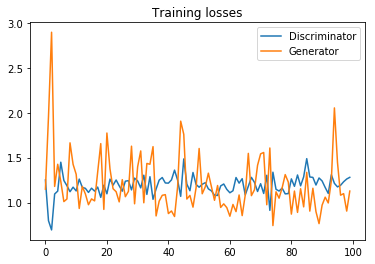

In [44]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label="Discriminator")
plt.plot(losses.T[1], label="Generator")
plt.title("Training losses")
plt.legend()

*Generator samples from training*

Let's see some samples from the generator.

In [45]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap="Greys_r")

In [46]:
# load samples from generator, taken while training
with open("train_samples.pkl", "rb") as f:
    samples = pkl.load(f)

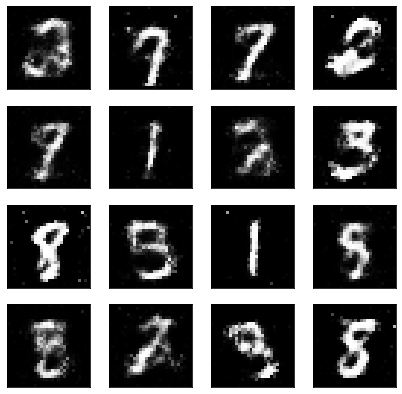

In [47]:
view_samples(-1, samples)

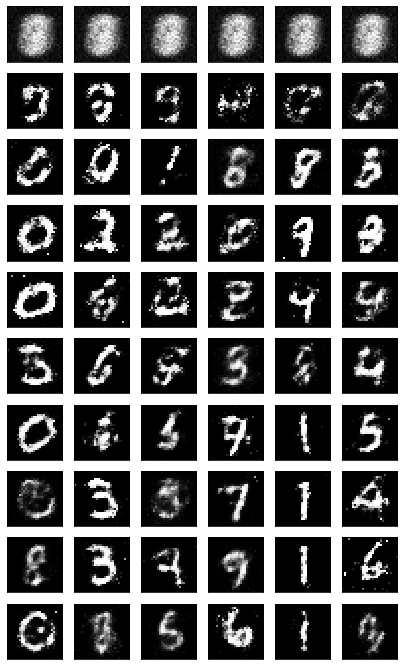

In [48]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

*Sampling from the generator*

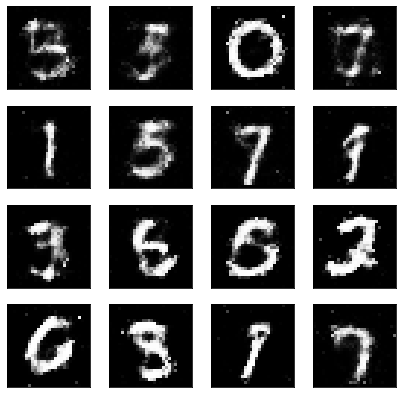

In [49]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

another

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

## References

+ [1] https://skymind.ai/wiki/generative-adversarial-network-gan
+ [2] https://forum.faceswap.dev/viewtopic.php?t=146
+ [3] https://developers.google.com/machine-learning/gan
+ [4] Salimans, T., Goodfellow, I., Zaremba, W., Cheung, V., Radford, A., & Chen, X. (2016). Improved techniques for training gans. In Advances in neural information processing systems (pp. 2234-2242).
+ [5] Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). Gans trained by a two time-scale update rule converge to a local nash equilibrium. In Advances in neural information processing systems (pp. 6626-6637).
+ [6] Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784.
+ [7] https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
+ [8] Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.
+ [9] https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
+ [10] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Leaky_ReLUs
+ [11] https://medium.com/intel-student-ambassadors/mnist-gan-detailed-step-by-step-explanation-implementation-in-code-ecc93b22dc60